# An [Uncertainties package](https://pythonhosted.org/uncertainties/) quick start

### The Uncertainties Package

Uncertainties will do almost all uncertainty propagation automatically.  You just need to create "uncertainty objects" which are Python custom types that have two parts: the "mean" and the "uncertainty".

Then for standard mathematical operations, one only needs to use these new objects in the calculation, and the uncertainty propagation occurs all by itself.

Here is an example:

In [22]:
# Usually import packages via a handle to the functions in them using import ... as ...
#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

#
import uncertainties as unc
%matplotlib inline

In [23]:
# Create uncertainty objects
# a "ufloat" has a value and an uncertainty

ua = unc.ufloat(3.0,0.3)
ub = unc.ufloat(4.0,0.4)
uc = unc.ufloat(7.0,0.5)

print("ua =",ua,"\nub =",ub,"\nuc =", uc)
print("ua + ub =", ua + ub)

ua = 3.00+/-0.30 
ub = 4.0+/-0.4 
uc = 7.0+/-0.5
ua + ub = 7.0+/-0.5


Notice how the uncertainty was propagated to the sum of `ua` and `ub` automatically.

The package also has useful formatting code.  It prints the value and uncertainty to the same precision (same number of digits past the decimal point). 

In [24]:
print('c = {:.2u}'.format(uc))

# The "P" tag looks prettier.  "P" stands for "pretty print."

print('c = {:.2uP}'.format(uc*1e10))

c = 7.00+/-0.50
c = (7.00±0.50)×10¹⁰


To get each piece back out, use the attributes `n` or `nominal_value` and `s` or `std_dev`:

In [25]:
print('c nominal value = {:.3f}'.format(uc.nominal_value))
print('c standard deviation = {:.3f}'.format(uc.s))
print('c fractional standard_deviation = {:.3f}'.format(abs(uc.s/uc.n)))
print('c percent uncertainty = {:.1%}'.format(abs(uc.s/uc.n)))

c nominal value = 7.000
c standard deviation = 0.500
c fractional standard_deviation = 0.071
c percent uncertainty = 7.1%


## Use example: Hall coefficient

In [26]:
# Read in Hall probe measurements

Al_data = pd.read_csv('Al_probe_measurements.csv')
Al_data

,I (mA),green_up (mV),green_dn (mV),2VH
0,10.1,0.0356,0.0358,0.0002
1,30.9,0.1027,0.1033,0.0006
2,50.4,0.1649,0.1667,0.0018
3,75.2,0.2442,0.2464,0.0022
4,96.4,0.3117,0.3149,0.0032
5,124.4,0.4007,0.4047,0.0040
6,145.6,0.4683,0.4732,0.0049
7,174.9,0.5619,0.5675,0.0056
8,199.2,0.6394,0.6461,0.0067


In [27]:
# Useful plot default
mpl.rcParams['figure.figsize'] = 8.0,6.0  # Roughly 12 cm wde by 8 cm high
mpl.rcParams['font.size'] = 14.0 # Use 14 point font

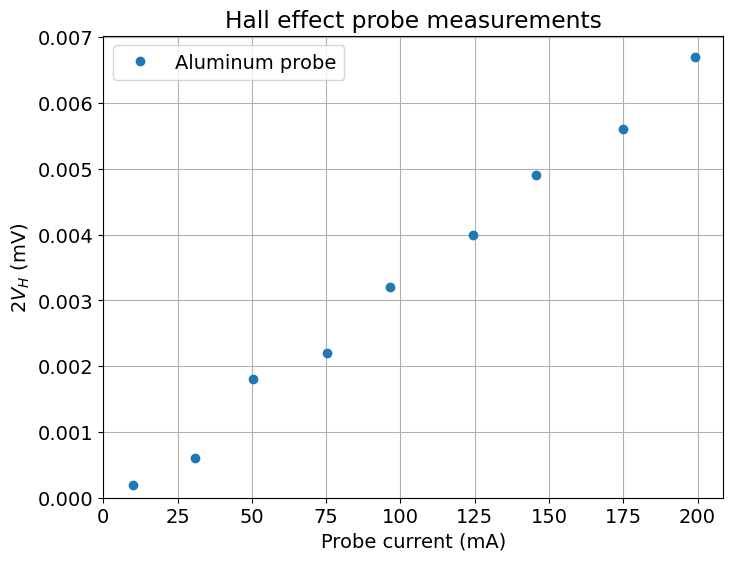

In [28]:
# See the examples for how to make a plot
# Metal first
plt.plot(Al_data['I (mA)'],Al_data['2VH'],'o',label="Aluminum probe")
plt.grid(True)
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.xlabel('Probe current (mA)')
plt.ylabel(r'$2V_H$ (mV)')
plt.title("Hall effect probe measurements")
plt.legend()



## Fit the data to extract the slope of $2V_H/I_x$

Use LMfit.  See the examples.

In [29]:
# Set  up the Model

# Import the Linear model.
# You only do this once in a notebook
from lmfit.models import LinearModel

# create an instance of the model
# You only need to do this once
line = LinearModel()


In [30]:
# Aluminum first
#
# Get starting parameters
Al_params = line.guess(Al_data['2VH'], x=Al_data['I (mA)'])

# Feed these into the fitter and run it.
Al_fit = line.fit(Al_data['2VH'], Al_params, x=Al_data['I (mA)'])

# Print the results
Al_fit

Text(0, 0.5, '$2V_H$ (mV)')

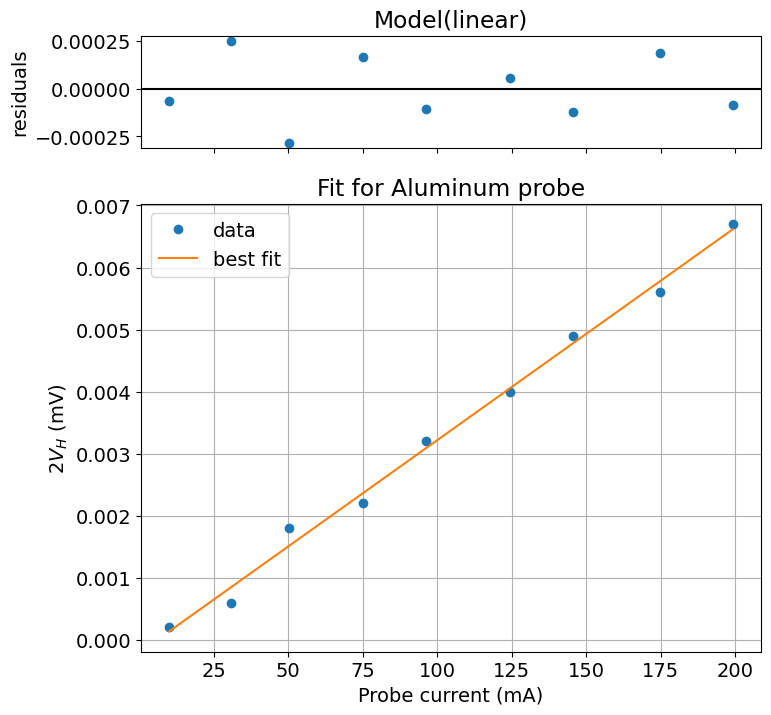

In [31]:
# Make a plot
Al_fit.plot()
plt.grid(True)
plt.title('Fit for Aluminum probe')
plt.xlabel('Probe current (mA)')
plt.ylabel(r'$2V_H$ (mV)')

### Extract the slope with uncertainty from the fit parameters


In [32]:
Al_slope = unc.ufloat(Al_fit.params['slope'].value, Al_fit.params['slope'].stderr)
print('2VH/Ix for aluminum = {:.2uP} V/A'.format(Al_slope))

2VH/Ix for aluminum = (3.43±0.10)×10⁻⁵ V/A


### Calculate the Hall coefficient

The Hall coefficient $R_H$ is related to the measurements by

$$V_H = -R_H\frac{I_xB_z}{t}$$ 

where $t$ is the thichness of the sample strip.  From the linefit, we have the slope $m = 2V_H/I_x$  so

$$R_H = -m\frac{t}{2B_z}$$

In the instructions there is a list of probe parameters.  Use these to calculate the Hall coefficient and its statistical uncertainty.

In [33]:
# For Al, from Table 1, create uncertainty object for thickness

# Probe thickness
ut = unc.ufloat(2.34e-7, 0.17e-7) # in meters

# The field strength of the magnet = 134.0714±0.7832 mT
uB = unc.ufloat(134.0714,0.7832)*1e-3 # in tesla

RH_Al = -Al_slope*ut/(2*uB) # B-field needs to be in unit of tesla

print('The Hall coefficient for the aluminum probe is {:.2uP} m^3/A-s'.format(RH_Al))


The Hall coefficient for the aluminum probe is (-2.99±0.24)×10⁻¹¹ m^3/A-s


### Obtain contributions to the calculated error

**Uncertainties** calculates according to the theory of "Linear Error Propagation" which assumes that the uncertainties are calcuated according to the formula 
$$ \sigma_f^2 = \left(\frac{\partial f}{\partial a}\right)^2\sigma_a^2 + 
                \left(\frac{\partial f}{\partial b}\right)^2\sigma_b^2 +
                \left(\frac{\partial f}{\partial c}\right)^2\sigma_c^2 + \ldots $$
where $f$ is a function of quantities $a, b, c, \ldots$.

You can obtain the contributions of uncertainty from each term in the above calculation through the `error_components()` method:

In [34]:
print('Error components:')
for (value, err_component) in RH_Al.error_components().items():
    print('{:.2uP} : {:.4g}'.format(value, err_component))

Error components:
134.07±0.78 : 1.747e-13
(2.34±0.17)×10⁻⁷ : 2.172e-12
(3.43±0.10)×10⁻⁵ : 8.815e-13


The error components have the same units as the final value of the calculation.  The calculated uncertainty is the square root of the sum of the squares of the error components.  Thus, the percent contribution of each item $x$ would be given by
$$ \frac{1}{\sigma_f^2}\left(\frac{\partial f}{\partial x}\right)^2\sigma_x^2\times 100$$

In [35]:
print('Percent contribution of error components to final uncertainty:')
for (value, err_component) in RH_Al.error_components().items():
    print('{:.2uP} : {:.1%}'.format(value, (err_component/RH_Al.std_dev)**2))

Percent contribution of error components to final uncertainty:
134.07±0.78 : 0.6%
(2.34±0.17)×10⁻⁷ : 85.4%
(3.43±0.10)×10⁻⁵ : 14.1%


By "tagging" the uncertainty object when it is built, you can label each item for this analysis:

In [36]:
# Add tags to each item in the calculation
Al_slope = unc.ufloat(Al_fit.params['slope'].value, Al_fit.params['slope'].stderr,tag='2VH/I')
uB = unc.ufloat(134.0714,0.7832,tag='B')*1e-3 # in tesla
ut = unc.ufloat(2.34e-7, 0.17e-7,tag='t') # in meters

RH_Al = -Al_slope*ut/(2*uB) # B-field needs to be in unit of tesla

print('The Hall coefficient for the aluminum probe is {:.2uP} m^3/A-s'.format(RH_Al))
print('\nPercent contribution of error components to final uncertainty:')
for (value, err_component) in RH_Al.error_components().items():
    print('{:>8s} : {:5.1%}'.format(value.tag, (err_component/RH_Al.std_dev)**2))

The Hall coefficient for the aluminum probe is (-2.99±0.24)×10⁻¹¹ m^3/A-s

Percent contribution of error components to final uncertainty:
       B :  0.6%
       t : 85.4%
   2VH/I : 14.1%
